In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
import cv2
import torch.distributions as td

In [2]:
random_seed = 111

In [3]:
origin_dataset = torch.load('moving_minst_data.pt')
print(origin_dataset.shape)
masks = torch.load('moving_minst_data_masks.pt')
sum_last_two = torch.sum(masks,dim=(-1,-2))
non_missing_index = sum_last_two!=0
origin_dataset = origin_dataset[non_missing_index].unsqueeze(1)
masks = masks[non_missing_index].unsqueeze(1)
print(origin_dataset.shape)
dataset=origin_dataset*masks

dataset_m = torch.cat((dataset,masks),dim=1)

torch.Size([10000, 1, 64, 64])
torch.Size([1000, 1, 64, 64])


In [60]:
for data in origin_dataset:
    if(data.sum((-1,-2))==0):
        print(data.sum((-1,-2)))

In [61]:
m=len(dataset)
print(m)
full_data, full_val_data = random_split(origin_dataset, [int(m-m*0.2), int(m*0.2)],generator=torch.Generator().manual_seed(random_seed))
train_data, val_data = random_split(dataset_m, [int(m-m*0.2), int(m*0.2)],generator=torch.Generator().manual_seed(random_seed))
batch_size=256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

6000


In [36]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size, stride, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size, stride, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size, stride, padding=1)  
        self.conv4 = nn.Conv2d(64, 128, kernel_size, stride, padding=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size, stride, padding=1)
        self.linear1 = nn.Linear(256*2*2, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = td.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        x = x.to(device)

        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.batch3(self.conv4(x)))
        x = F.relu(self.conv5(x))
      
        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.linear1(x))

        mu =  self.linear2(x)
        log_var = self.linear3(x)
        sigma = torch.exp(0.5 * log_var)
        
        rand_state = torch.random.get_rng_state()[0]
        torch.random.manual_seed(rand_state+1)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl=-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),dim=1)
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z   
    

In [37]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 256*2*2),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 2, 2))

        self.decoder_conv = nn.Sequential(

            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size, stride, padding=1, output_padding=1),
            nn.Upsample(size=(64,64))
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        
        x = torch.sigmoid(x)
        return x

In [38]:
class GaussianDecoder(Decoder):
    def forward(self, x):
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)

        x = torch.sigmoid(x)
       
        var = torch.ones_like(x)
        
        return td.Normal(loc=x, scale=var)

In [39]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = GaussianDecoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [40]:
### Set the random seed for reproducible results
torch.manual_seed(random_seed)

kernel_size = [3,3]
stride=[2,2]

d = 11

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=1024, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=11, bias=True)
    (linear3): Linear(in_features=128, out_features=11, bias=True)
  )
  (decoder): GaussianDecoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): ReLU(inplace=Tr

In [41]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for data in dataloader: 
        # Move tensor to the proper device
        x = data[:,:1,:,:]
        mask = data[:,1:,:,:]
        x = x.to(device)
        mask = mask.to(device)
        px_z = vae(x)

        temp_mask = mask.squeeze().flatten(1,2)
        mask_sum = temp_mask.sum(1)
        boolen_mask = (mask_sum == 0)
        temp_mask[boolen_mask] = 1
        temp_mask = temp_mask.reshape(mask.shape)
        
        # Evaluate loss
        nll = (-px_z.log_prob(x)*temp_mask).sum((1,2,3)).mean()

        kl = vae.encoder.kl.mean()

        loss = nll + kl*0.1
        # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
      
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        nll_loss += nll.item()
        kl_loss += kl.item()

        train_loss+=loss.item()
        

    return train_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [42]:
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for data in dataloader:
            # Move tensor to the proper device
            x = data[:,:1,:,:]
            mask = data[:,1:,:,:]
            x = x.to(device)
            mask = mask.to(device)
            temp_mask = mask.squeeze().flatten(1,2)
            mask_sum = temp_mask.sum(1)
            boolen_mask = (mask_sum ==0)
            temp_mask[boolen_mask] = 1
            temp_mask = temp_mask.reshape(mask.shape)
            
            # Encode data
            # encoded_data = vae.encoder(x)
            # decoded_data = vae.decoder(encoded_data)
            # print(decoded_data.size())
            # Decode data
            px_z = vae(x)
        
        # Evaluate loss
            nll = (-px_z.log_prob(x)*temp_mask).sum((1,2,3)).mean()

            kl = vae.encoder.kl.mean()

            loss = nll + kl*0.1
            
            
            # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            nll_loss += nll.item()
            kl_loss += kl.item()

          
            val_loss += loss.item()

    return val_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [55]:
def plot_ae_outputs(encoder,decoder,n=10,random_seed = random_seed):
    fig, axs = plt.subplots(10, 2,figsize=(30,100))
    # targets = [item[0] for item in test_data]
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    i=0
    random.seed(random_seed)
    for index in random.sample(range(len(val_data)), n):
      img = val_data[index][:1].unsqueeze(0).to(device)
      print(val_data[index][:1].sum((-1,-2)))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img)).mean
      axs[i,0].imshow(img.cpu().squeeze().numpy(), cmap='gray')
     
      axs[i,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')
      i=i+1

In [47]:
num_epochs = 100

train_loss_sum = []
train_nll_sum = []
train_kl_sum = []
val_loss_sum = []
val_nll_sum = []
val_kl_sum = []
for epoch in range(num_epochs):
   train_loss,train_nll_loss,train_kl_loss = train_epoch(vae,device,train_loader,optim)
   val_loss,val_nll_loss,val_kl_loss = test_epoch(vae,device,valid_loader)
   train_loss_sum.append(train_loss)
   train_nll_sum.append(train_nll_loss)
   train_kl_sum.append(train_kl_loss)
   val_loss_sum.append(val_loss)
   val_nll_sum.append(val_nll_loss)
   val_kl_sum.append(val_kl_loss)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t train nll loss {:.3f} \t train kl loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,train_nll_loss,train_kl_loss))
   print('\n val loss {:.3f} \t val nll loss {:.3f} \t val kl loss {:.3f}'.format(val_loss,val_nll_loss,val_kl_loss))
   # plot_ae_outputs(vae.encoder,vae.decoder,n=10)


 EPOCH 1/100 	 train loss 1682.656 	 train nll loss 1681.197 	 train kl loss 14.587

 val loss 1792.837 	 val nll loss 1791.277 	 val kl loss 15.603

 EPOCH 2/100 	 train loss 1682.441 	 train nll loss 1680.966 	 train kl loss 14.746

 val loss 1792.634 	 val nll loss 1791.082 	 val kl loss 15.520

 EPOCH 3/100 	 train loss 1682.351 	 train nll loss 1680.878 	 train kl loss 14.732

 val loss 1792.299 	 val nll loss 1790.751 	 val kl loss 15.479

 EPOCH 4/100 	 train loss 1682.390 	 train nll loss 1680.916 	 train kl loss 14.738

 val loss 1792.479 	 val nll loss 1790.848 	 val kl loss 16.307

 EPOCH 5/100 	 train loss 1682.399 	 train nll loss 1680.895 	 train kl loss 15.040

 val loss 1792.305 	 val nll loss 1790.780 	 val kl loss 15.251

 EPOCH 6/100 	 train loss 1682.583 	 train nll loss 1681.068 	 train kl loss 15.147

 val loss 1792.365 	 val nll loss 1790.769 	 val kl loss 15.963

 EPOCH 7/100 	 train loss 1682.630 	 train nll loss 1681.145 	 train kl loss 14.858

 val loss 1792

tensor([0.])
tensor([57.7255])
tensor([0.])
tensor([183.9569])
tensor([206.7686])
tensor([183.7843])
tensor([0.])
tensor([17.1333])
tensor([216.4196])
tensor([205.3608])


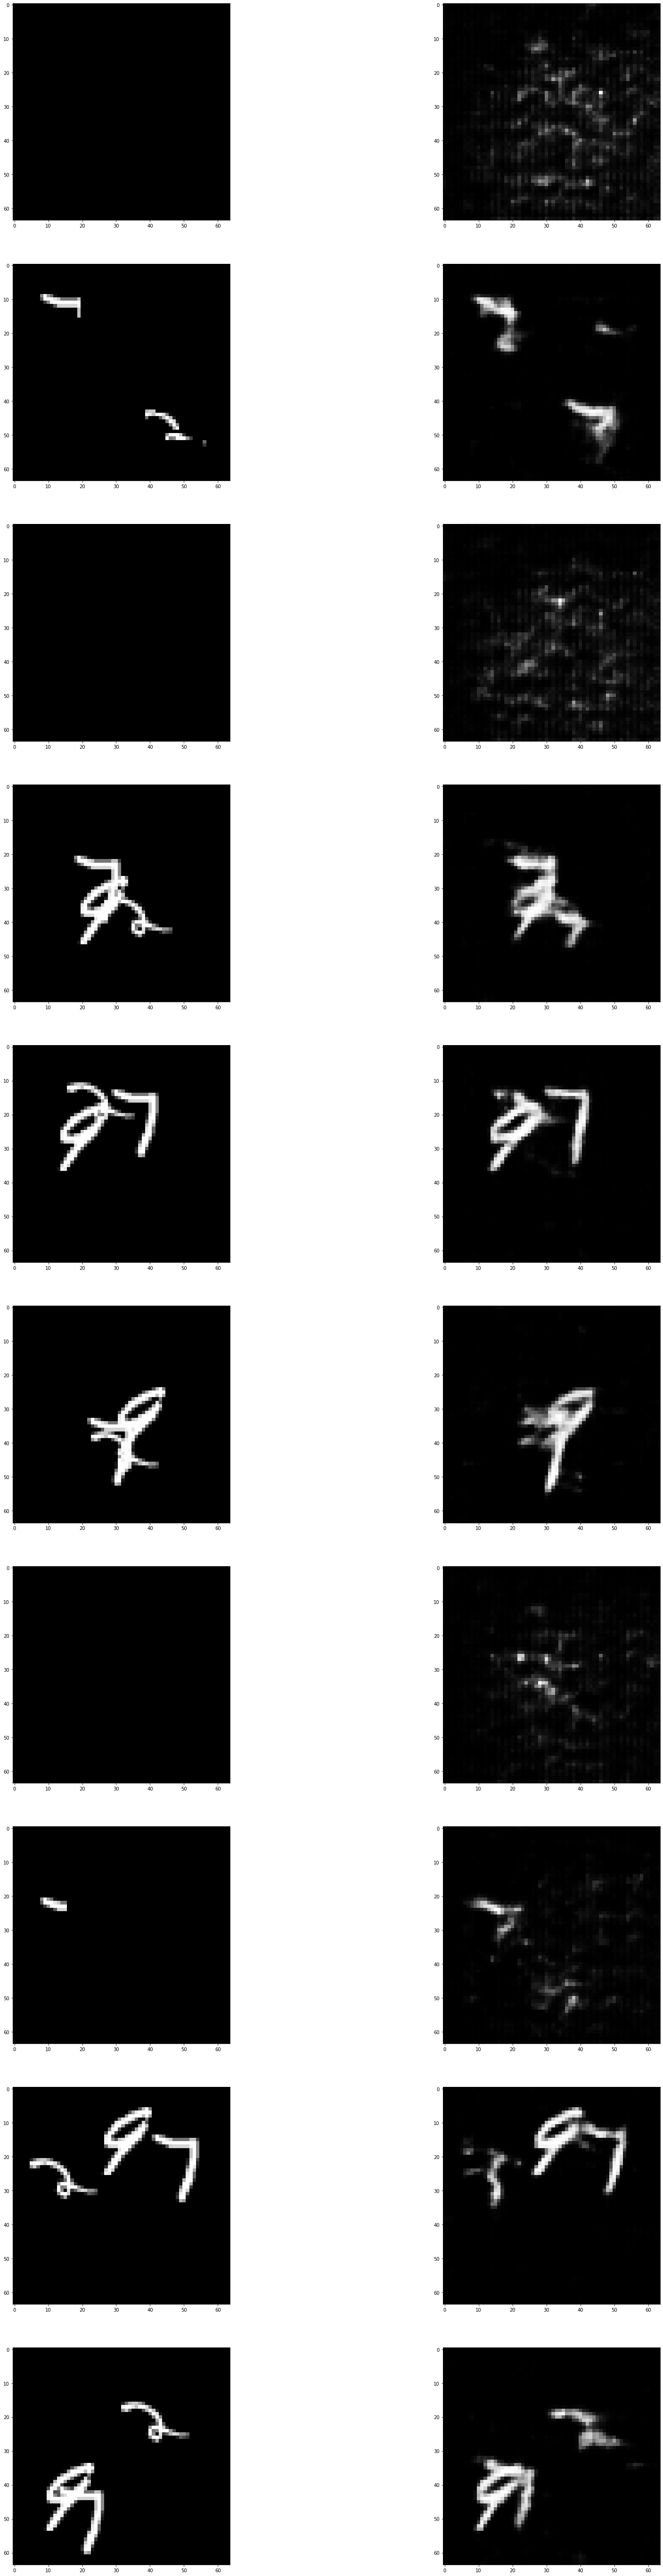

In [56]:
plot_ae_outputs(vae.encoder,vae.decoder,n=10,random_seed = 111)

Text(0, 0.5, 'Kl Loss')

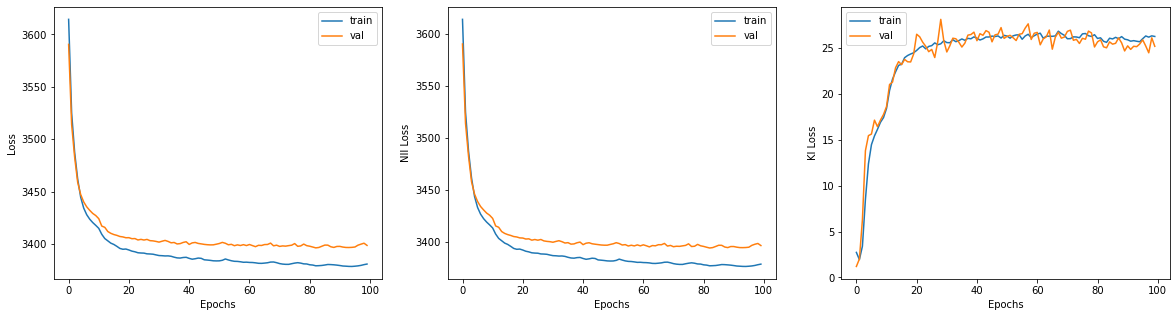

In [15]:
fig, axs = plt.subplots(1, 3,figsize=(20,5))

axs[0].plot(train_loss_sum, label="train")
axs[0].plot(val_loss_sum,label = "val")
axs[0].legend()
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].plot(train_nll_sum, label="train")
axs[1].plot(val_nll_sum,label = "val")
axs[1].legend()
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Nll Loss")
axs[2].plot(train_kl_sum, label="train")
axs[2].plot(val_kl_sum,label = "val")
axs[2].legend()
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Kl Loss")

In [16]:
def ssim(img1, img2):
    C1 = (0.01 * 1)**2
    C2 = (0.03 * 1)**2

    # img1 = img1.astype(np.float64)
    # img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [17]:
seqlen=10
test_predict_loss = 0.0
test_impu_loss = 0.0
test_impu_part_loss = 0.0
impuated_data_sum = 0
test_psnr = 0
test_ssim =0
input_dataset = val_data
compare_dataset = full_val_data
with torch.no_grad():

    for i in range(len(input_dataset)):
        
        x = input_dataset[i][:1]
      
        y = compare_dataset[i].squeeze()

        input_image = x.unsqueeze(0)
  
        predict_image = vae.decoder(vae.encoder(input_image)).mean.squeeze().cpu()

        image_mask = input_dataset[i][1:].squeeze()
        impuated_data_sum+=(image_mask.flatten()==0).sum().item()
   
        imputed_part = predict_image*(1-image_mask)
        full_part = y*(1-image_mask)

        
        loss_p = (abs(predict_image - y)/(predict_image.size(0)*predict_image.size(1))).sum()
        loss_ip = (abs(imputed_part - full_part)).sum()
        mse= (((predict_image - y)**2)/(predict_image.size(0)*predict_image.size(1))).sum()
        
        
        psnr = 20*math.log10(1/math.sqrt(mse))
        test_psnr += psnr
       
        test_predict_loss += loss_p.item()
       
        test_impu_part_loss += loss_ip.item()
        ssim_p = ssim(predict_image.cpu().detach().numpy(),y.cpu().detach().numpy())
        test_ssim +=ssim_p
       


print(test_predict_loss / len(input_dataset))
print(test_impu_part_loss / impuated_data_sum)
print(test_psnr / len(input_dataset))
print(test_ssim / len(input_dataset))

0.04539021470397711
0.07336491431071859
17.125254391799334
0.6879477976113558
